<a href="https://colab.research.google.com/github/baseerx/Pakistan-Election-Data-Analysis/blob/main/election_analytics_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql.functions import col, max, when,regexp_replace, col,count,sum as spark_sum,countDistinct,lit
from pyspark.sql.types import FloatType
import plotly.graph_objects as go
import plotly.express as px
from pyspark.sql.functions import collect_list



**Mount google drive and create spark session**


In [56]:
drive.mount('/content/gdrive')


spark = SparkSession.builder \
    .appName("ElectionData") \
    .getOrCreate()

Mounted at /content/gdrive


**Defining file paths**

In [57]:
# Define the file paths
file_path_2002 = '/content/gdrive/MyDrive/Colab Notebooks/Data/National Assembly Result 2002.csv'
file_path_2008 = '/content/gdrive/MyDrive/Colab Notebooks/Data/National Assembly Result 2008.csv'
file_path_2013 = '/content/gdrive/MyDrive/Colab Notebooks/Data/National Assembly Result 2013.csv'
file_path_2018 = '/content/gdrive/MyDrive/Colab Notebooks/Data/National Assembly Results 2018.csv'




**Read the CSV - Loading Data**

In [58]:
df02 = spark.read.csv(file_path_2002, header=True, inferSchema=True)
df08 = spark.read.csv(file_path_2008, header=True, inferSchema=True)
df13 = spark.read.csv(file_path_2013, header=True, inferSchema=True)
df18 = spark.read.csv(file_path_2018, header=True, inferSchema=True)



In [59]:
df02.columns

['District',
 'Seat',
 'Constituency_title',
 'Candidate_Name',
 'Party',
 'Votes',
 'Total_Valid_Votes',
 'Total_Rejected_Votes',
 'Total_Votes',
 'Total_Registered_Voters',
 'Turnout']

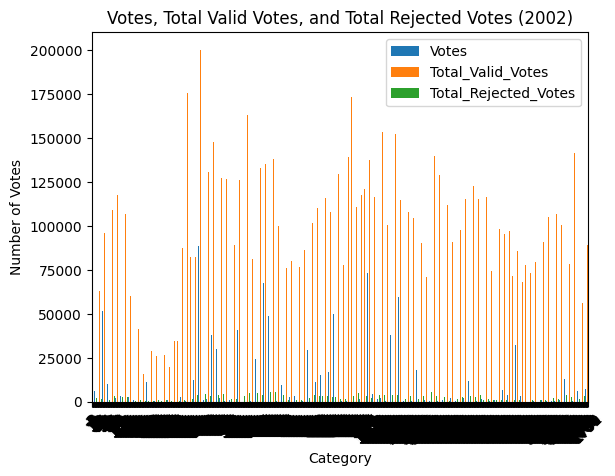

In [60]:
# Assuming df02 is your PySpark DataFrame
# Select the desired columns
df02_selected = df02.select('Votes', 'Total_Valid_Votes', 'Total_Rejected_Votes')

# Convert PySpark DataFrame to pandas DataFrame
df02_pandas = df02_selected.toPandas()

# Create the bar chart
df02_pandas.plot(kind='bar')

# Add title and labels
plt.title('Votes, Total Valid Votes, and Total Rejected Votes (2002)')
plt.xlabel('Category')
plt.ylabel('Number of Votes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


**Displaying shapes of all dataframes**


In [61]:
# prompt: display shapes of all dfs

print(f"df02 shape: {df02.count()}, {len(df02.columns)}")
print(f"df08 shape: {df08.count()}, {len(df08.columns)}")
print(f"df13 shape: {df13.count()}, {len(df13.columns)}")
print(f"df18 shape: {df18.count()}, {len(df18.columns)}")


df02 shape: 1793, 11
df08 shape: 2316, 11
df13 shape: 4542, 12
df18 shape: 3428, 12


**Columns Transformation**

In [62]:
# prompt: remove _ from df02 and df18 column names and concat

# Remove underscores from column names in df02 and df18
df02 = df02.toDF(*[c.replace("_", "") for c in df02.columns])
df18 = df18.toDF(*[c.replace("_", "") for c in df18.columns])




In [63]:
# prompt: displaying info of all dataframes

df02.printSchema()
df08.printSchema()
df13.printSchema()
df18.printSchema()


root
 |-- District: string (nullable = true)
 |-- Seat: string (nullable = true)
 |-- Constituencytitle: string (nullable = true)
 |-- CandidateName: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Votes: integer (nullable = true)
 |-- TotalValidVotes: integer (nullable = true)
 |-- TotalRejectedVotes: integer (nullable = true)
 |-- TotalVotes: integer (nullable = true)
 |-- TotalRegisteredVoters: integer (nullable = true)
 |-- Turnout: double (nullable = true)

root
 |-- _c0: integer (nullable = true)
 |-- Seat: string (nullable = true)
 |-- ConstituencyTitle: string (nullable = true)
 |-- CandidateName: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Votes: integer (nullable = true)
 |-- TotalValidVotes: integer (nullable = true)
 |-- TotalRejectedVotes: integer (nullable = true)
 |-- TotalVotes: integer (nullable = true)
 |-- TotalRegisteredVoters: integer (nullable = true)
 |-- Turnout: string (nullable = true)

root
 |-- _c0: integer (nullable

In [64]:
# prompt: show only the following columns from DFs

# Select the desired columns from each dataframe
df02_selected = df02.select('TotalRegisteredVoters','TotalVotes','Votes', 'TotalValidVotes', 'TotalRejectedVotes','Turnout')
df08_selected = df08.select('TotalRegisteredVoters','TotalVotes','Votes', 'TotalValidVotes', 'TotalRejectedVotes','Turnout')
df13_selected = df13.select('TotalRegisteredVoters','TotalVotes','Votes', 'TotalValidVotes', 'TotalRejectedVotes','Turnout')
df18_selected = df18.select('TotalRegisteredVoters','TotalVotes','Votes', 'TotalValidVotes', 'TotalRejectedVotes','Turnout')

# Display the selected columns
print("df02_selected:")
df02_selected.show()

print("df08_selected:")
df08_selected.show()

print("df13_selected:")
df13_selected.show()

print("df18_selected:")
df18_selected.show()

df02_selected:
+---------------------+----------+-----+---------------+------------------+-------+
|TotalRegisteredVoters|TotalVotes|Votes|TotalValidVotes|TotalRejectedVotes|Turnout|
+---------------------+----------+-----+---------------+------------------+-------+
|               233907|     67194| 2029|          65642|              1552|  28.73|
|               233907|     67194|37179|          65642|              1552|  28.73|
|               233907|     67194|23002|          65642|              1552|  28.73|
|               233907|     67194| 1537|          65642|              1552|  28.73|
|               233907|     67194| 1417|          65642|              1552|  28.73|
|               216587|     57367|15771|          56000|              1367|  26.49|
|               216587|     57367|  926|          56000|              1367|  26.49|
|               216587|     57367|37728|          56000|              1367|  26.49|
|               226299|     69312| 8838|          67357|     

**Cleaning the Turnout column from special chars**

> Add blockquote



In [65]:
# List of selected DataFrames
dfs = [df02_selected, df08_selected, df13_selected, df18_selected]

# Regular expression patterns to remove special characters and percentages
pattern = r'[^0-9.]'  # This pattern removes anything that's not a digit or a period

# Loop through each DataFrame and clean the Turnout column
for i in range(len(dfs)):
    # Clean the Turnout column by removing special characters and percentages
    dfs[i] = dfs[i].withColumn('Turnout', regexp_replace(col('Turnout'), pattern, ''))

    # Convert the cleaned Turnout column to a float
    dfs[i] = dfs[i].withColumn('Turnout', col('Turnout').cast('float'))

    # Remove values greater than 100 from the Turnout column
    dfs[i] = dfs[i].filter(col('Turnout') <= 100)



In [66]:
# Display the 'Turnout' column values from the first DataFrame
dfs[0].select('Turnout').show()


+-------+
|Turnout|
+-------+
|  28.73|
|  28.73|
|  28.73|
|  28.73|
|  28.73|
|  26.49|
|  26.49|
|  26.49|
|  30.63|
|  30.63|
|  30.63|
|  30.63|
|  30.63|
|  30.63|
|  29.61|
|  29.61|
|  29.61|
|  29.61|
|  29.61|
|  37.41|
+-------+
only showing top 20 rows



In [67]:
# Define the number of decimal places for rounding
decimal_places = 2  # You can change this value to the desired number of decimal places

# Pick the maximum value from the 'Turnout' column and round off the decimal values
max_turnout_df0 = round(dfs[0].agg({'Turnout': 'max'}).collect()[0][0], decimal_places)
print("Maximum Turnout value from the first DataFrame - election 2002:", max_turnout_df0)

max_turnout_df1 = round(dfs[1].agg({'Turnout': 'max'}).collect()[0][0], decimal_places)
print("Maximum Turnout value from the first DataFrame - election 2008:", max_turnout_df1)

max_turnout_df2 = round(dfs[2].agg({'Turnout': 'max'}).collect()[0][0], decimal_places)
print("Maximum Turnout value from the first DataFrame - election 2013:", max_turnout_df2)

max_turnout_df3 = round(dfs[3].agg({'Turnout': 'max'}).collect()[0][0], decimal_places)
print("Maximum Turnout value from the first DataFrame - election 2018:", max_turnout_df3)


Maximum Turnout value from the first DataFrame - election 2002: 62.84
Maximum Turnout value from the first DataFrame - election 2008: 67.0
Maximum Turnout value from the first DataFrame - election 2013: 84.77
Maximum Turnout value from the first DataFrame - election 2018: 70.91


In [68]:


# Maximum Turnout values
max_turnouts = [max_turnout_df0, max_turnout_df1, max_turnout_df2, max_turnout_df3]
election_years = ['2002', '2008', '2013', '2018']

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=election_years, y=max_turnouts)])

# Update layout
fig.update_layout(title='Maximum Turnout Values by Election Year',
                  xaxis_title='Election Year',
                  yaxis_title='Maximum Turnout',
                  yaxis_tickformat=".2f%",  # Display y-axis as percentage with 2 decimal places
                  )

# Show the plot
fig.show()




In [69]:
df13 = df13.withColumn('Turnout', when(df13['Turnout'].isNull() | (df13['Turnout'] == ''), 0).otherwise(df13['Turnout']))


**Checking if there is any null values**

In [70]:
# Display the 'CandidateName' column values from the df18 DataFrame
df18.select('CandidateName').show()


+--------------------+
|       CandidateName|
+--------------------+
|Moulana Abdul Akb...|
|     Saeed ur Rehman|
|      Muhammad Yahya|
|Shahzada Muhammad...|
|      Eid Ul Hussain|
|      Muhammad Amjad|
|       Taqdira Ajmal|
|         Abdul Latif|
|     Iftikhar Ud Din|
|     Nisar Dastageer|
|         Saleem Khan|
|     Haider Ali Khan|
|    Muhammad Mukhtar|
|       Ishtiaq Ahmad|
|Malak Muhammad Di...|
|      Miraj Muhammad|
|        Mumtaz Ahmad|
|          Amir Muqam|
|          Said Qamar|
|        Naveed Iqbal|
+--------------------+
only showing top 20 rows



In [71]:
# Sample data for df18 (this would be replaced with the actual loading of df18)
# df18 = spark.read.csv(file_path_2018, header=True, inferSchema=True)

# Aggregate the data to count the number of unique constituencies per district
district_constituency_count = df18.groupBy('district').agg(countDistinct('ConstituencyTitle').alias('ConstituencyCount'))

# Convert the result to a Pandas DataFrame
district_constituency_count_pd = district_constituency_count.toPandas()

# Create a bar chart using Plotly Express
fig = px.bar(district_constituency_count_pd, x='district', y='ConstituencyCount',
             title='Number of Constituencies per District',
             labels={'district': 'District', 'ConstituencyCount': 'Number of Constituencies'})

# Display the plot
fig.show()

In [72]:
# Assuming the correct column name for district information is 'Seat' (replace 'Seat' with the actual column name if different)
district_column = 'Seat'  # Replace this with the actual column name for district if it is different

# Aggregate the data to count the number of unique constituencies per district
district_constituency_count = df13.groupBy(district_column).agg(countDistinct('ConstituencyTitle').alias('ConstituencyCount'))

# Convert the result to a Pandas DataFrame
district_constituency_count_pd = district_constituency_count.toPandas()

# Create a bar chart using Plotly Express
fig = px.bar(district_constituency_count_pd, x=district_column, y='ConstituencyCount',
             title='Number of Constituencies per District',
             labels={district_column: 'District', 'ConstituencyCount': 'Number of Constituencies'})

# Display the plot
fig.show()

In [73]:
print("Schema for df02:")
df02.printSchema()

print("\nSchema for df08:")
df08.printSchema()

print("\nSchema for df13:")
df13.printSchema()

print("\nSchema for df18:")
df18.printSchema()


Schema for df02:
root
 |-- District: string (nullable = true)
 |-- Seat: string (nullable = true)
 |-- Constituencytitle: string (nullable = true)
 |-- CandidateName: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Votes: integer (nullable = true)
 |-- TotalValidVotes: integer (nullable = true)
 |-- TotalRejectedVotes: integer (nullable = true)
 |-- TotalVotes: integer (nullable = true)
 |-- TotalRegisteredVoters: integer (nullable = true)
 |-- Turnout: double (nullable = true)


Schema for df08:
root
 |-- _c0: integer (nullable = true)
 |-- Seat: string (nullable = true)
 |-- ConstituencyTitle: string (nullable = true)
 |-- CandidateName: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Votes: integer (nullable = true)
 |-- TotalValidVotes: integer (nullable = true)
 |-- TotalRejectedVotes: integer (nullable = true)
 |-- TotalVotes: integer (nullable = true)
 |-- TotalRegisteredVoters: integer (nullable = true)
 |-- Turnout: string (nullable = true

In [74]:
# prompt: replace Part column name with Party
# in df18

df18 = df18.withColumnRenamed('Part', 'Party')


In [75]:
# Aggregate the data to count the number of seats won by each party
party_seat_counts = df18.groupBy("Party").agg(count("Seat").alias("SeatsWon"))

# Show the result
party_seat_counts.show()

+--------------------+--------+
|               Party|SeatsWon|
+--------------------+--------+
|Tehreek-e-Labbaik...|     175|
|Tehreek-e-Suba Ha...|       1|
|Pakistan Awami Le...|       3|
|Jamote Qaumi Move...|       1|
|Jannat Pakistan P...|       3|
|Tehreek Jawanan P...|       7|
|Grand Democratic ...|      29|
|Jamiat Ulma-e-Isl...|      10|
|Aam Admi Tehreek ...|       1|
|  Amun Taraqqi Party|      13|
|Pakistan Awami In...|       2|
|Pakistan Peoples ...|       1|
|Tehreek-e-Labbaik...|      22|
|Balochistan Natio...|      13|
|Awami National Party|      61|
|Pakistan Muslim L...|       1|
|  Sindh United Party|       9|
|All Pakistan Musl...|       3|
|Pakistan Muslim L...|      15|
|Front National (P...|       1|
+--------------------+--------+
only showing top 20 rows



In [77]:
# Assuming you have already aggregated the data in party_seat_counts DataFrame

# Create a bar chart using Plotly Express
fig = px.bar(party_seat_counts.toPandas(), x='Party', y='SeatsWon',
             title='Number of Seats Won by Each Party',
             labels={'Party': 'Party', 'SeatsWon': 'Number of Seats'})

# Display the plot
fig.show()

In [79]:
# Group the DataFrame by ConstituencyTitle and collect the list of candidates for each constituency
candidates_per_constituency = df18.groupBy("ConstituencyTitle").agg(collect_list("CandidateName").alias("Candidates"))

# Show the result
candidates_per_constituency.show(truncate=False)

+-----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ConstituencyTitle|Candidates                                                                                                                                                                                                                                                                                                                                        |
+-----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [85]:

# Convert the candidates_per_constituency DataFrame to Pandas
candidates_per_constituency_pd = candidates_per_constituency.toPandas()

# Create a bar chart using Plotly Express
fig = px.bar(candidates_per_constituency_pd, y='ConstituencyTitle',
             x='Candidates',
             orientation='h',
             title='Number of Candidates per Constituency',
             labels={'ConstituencyTitle': 'Constituency', 'Candidates': 'Number of Candidates'})

# Display the plot
fig.show()